In [139]:
import distutils.util
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import math

# assuming running from raycasting-simulation/Automator
sys.path.append("../PycastWorld")

from math import acos, asin, atan, cos, sin, tan, pi
from math import floor
from math import radians
from pycaster import PycastWorld, Turn, Walk
from numpy.random import default_rng

rng = default_rng()

# NOISE CONTROL
# the standard deviation of the Gaussian that random angles are drawn from
rand_angle_scale = pi / 36  # 5 degree s.d.

# the minimum of the uniform distribution that random distances (to move) are drawn from
rand_step_scale = 0.4

enws = {"Dir.EAST": 0, "Dir.NORTH": 90, "Dir.WEST": 180, "Dir.SOUTH": 270}


def in_targ_cell(base_dir, c_targ_x, c_targ_y, x, y):
    if base_dir == 0 or base_dir == 180:
        if abs(c_targ_x - x) < 0.4:
            return True
    else:
        if abs(c_targ_y - y) < 0.4:
            return True
    return False


class Driver:
    def __init__(
        self, c_targ_x, c_targ_y, base_dir, targ_dir, world, img_dir=None, show_freq=0, abs_base_dir=0
        
    ):
        self.c_targ_x = c_targ_x
        self.c_targ_y = c_targ_y
        self.base_dir = base_dir
        self.targ_dir = targ_dir

        self.prev_targ_angle = 0

        self.world = world
        self.curr_x = self.world.x()
        self.curr_y = self.world.y()

        self.direction = 0
        self.update_direction()

        self.dist = math.inf
        self.update_dist()

        self.angle = 0
        self.step = math.inf

        self.all_angles = np.array([])
        self.all_base_angles = np.array([])
        
        self.abs_base_dir = abs_base_dir

        self.img_dir = img_dir
        if self.img_dir != None:
            stack_conds = []
            stack_conds.append(os.path.isdir(os.path.join(img_dir, "left")))
            stack_conds.append(os.path.isdir(os.path.join(img_dir, "right")))
            stack_conds.append(os.path.isdir(os.path.join(img_dir, "straight")))

            # if subdirectories exist, then stacking method not used
            if all(stack_conds):
                self.img_num_l = len(os.listdir(os.path.join(img_dir, "left")))
                self.img_num_r = len(os.listdir(os.path.join(img_dir, "right")))
                self.img_num_s = len(os.listdir(os.path.join(img_dir, "straight")))
                self.stack_dir = False
            else:
                self.img_num = len(os.listdir(img_dir))
                self.stack_dir = True

        self.show_freq = show_freq

    def update_dist(self):
        self.dist = math.sqrt(
            (self.c_targ_x - self.world.x()) ** 2
            + (self.c_targ_y - self.world.y()) ** 2
        )

    def update_direction(self):
        if not -1 <= self.world.get_dir_x() <= 1:
            dir_x = round(self.world.get_dir_x())
        else:
            dir_x = self.world.get_dir_x()

        if not -1 <= self.world.get_dir_y() <= 1:
            dir_y = round(self.world.get_dir_y())
        else:
            dir_y = self.world.get_dir_y()

        if dir_x > 0 and dir_y >= 0:
            dir = acos(dir_x)
        elif dir_x <= 0 and dir_y >= 0:
            dir = acos(dir_x)
        elif dir_x < 0 and dir_y < 0:
            dir = pi - asin(dir_y)
        elif dir_x >= 0 and dir_y < 0:
            dir = asin(dir_y)

        self.direction = dir % (2 * pi)

    # adjust for smoother path
    def modified_targ(self, delta):
        if self.base_dir == 0 or self.base_dir == 180:
            if self.targ_dir == 90:
                return self.c_targ_x, self.c_targ_y + delta
            elif self.targ_dir == 270:
                return self.c_targ_x, self.c_targ_y - delta
        elif self.base_dir == 90 or self.base_dir == 270:
            if self.targ_dir == 0:
                return self.c_targ_x + delta, self.c_targ_y
            elif self.targ_dir == 180:
                return self.c_targ_x - delta, self.c_targ_y
        return self.c_targ_x, self.c_targ_y

    def get_angle(self):
        mod_x, mod_y = self.modified_targ(0.15)
        if self.curr_x <= mod_x and self.curr_y <= mod_y:
            if mod_x == self.curr_x:
                theta = pi / 2
            else:
                theta = (atan((mod_y - self.curr_y) / (mod_x - self.curr_x))) % (2 * pi)

        # case where target pos is up and to the left
        elif self.curr_x > mod_x and self.curr_y <= mod_y:
            if mod_y == self.curr_y:
                theta = pi
            else:
                theta = (atan((self.curr_x - mod_x) / (mod_y - self.curr_y))) % (2 * pi) + pi / 2

        # case where target pos is down and to the left
        elif self.curr_x > mod_x and self.curr_y > mod_y:
            if mod_x == self.curr_x:
                theta = 3 * pi / 2
            else:
                theta = (atan((self.curr_y - mod_y) / (self.curr_x - mod_x))) % (2 * pi) + pi

        # case where target pos is down and to the right
        else:
            if self.curr_y == mod_y:
                theta = 0
            else:
                theta = (atan((mod_x - self.curr_x) / (self.curr_y - mod_y))) % (2 * pi) + 3 * pi / 2
        return theta

    def set_rand_angle(self):
        theta = self.get_angle()
        self.angle = rng.normal(loc=theta, scale=rand_angle_scale) % (2 * pi)

    def set_rand_step(self):
        self.step = rng.uniform(rand_step_scale, self.dist_to_wall())

    def abs_angle_diff(self, angle):
        abs_diff = abs(self.direction - angle)
        return abs_diff % (2 * pi)

    def turn_right(self, angle):
        if self.direction > angle:
            if self.direction - angle > pi:
                return False
            else:
                return True
        else:
            if angle - self.direction > pi:
                return True
            else:
                return False

    def turn_to_angle(self):
        self.world.walk(Walk.Stop)
        i = 0
        prev_turn = None
        turn_angle = 0.0
        angle_deg = self.angle * (180/pi)
        num_turns = 1

#         print(f"abs_ base dir: {self.abs_base_dir}")
#         curr_dir = self.world.directions() * (180/pi)
                
        while self.abs_angle_diff(self.angle) > 0.1:
            if self.turn_right(self.angle):
                if prev_turn == "left":
                    print("no left to right allowed")
                    break
                
                agent_dir = -abs(90 + turn_angle)
       
                angle_label = agent_dir
#                 print(f"RIGHT DIR: {turn_angle}")
#                 print(f"RIGHT LABEL: {angle_label}")
                self.all_angles = np.append(self.all_angles, angle_label)
                if self.img_dir != None:
                    if self.stack_dir:
                        self.world.save_png(
                            os.path.join(
                                self.img_dir, f"{self.img_num:05}_{angle_label}.png",
                            )
                        )
                        self.img_num += 1
                    else:
                        self.world.save_png(
                            os.path.join(
                                self.img_dir,
                                "right",
                                f"{self.img_num_r:05}_{angle_label}.png",
                            )
                        )
                        self.img_num_r += 1

                self.world.turn(Turn.Right)
                turn_angle -= 2.5  # self.world.getTurnSpeed() * (180 / pi)
                self.world.update()

                prev_turn = "right"

            else:
                if prev_turn == "right":
                    print("no right to left allowed")
                    break
                    
                agent_dir = abs(90 - turn_angle)

                angle_label = agent_dir
#                 print(f"LEFT DIR: {turn_angle}")
#                 print(f"LEFT LABEL: {angle_label}")
                self.all_angles = np.append(self.all_angles, angle_label)                
                if self.img_dir != None:
                    if self.stack_dir:
                        self.world.save_png(
                            os.path.join(
                                self.img_dir, f"{self.img_num:05}_{angle_label}.png",
                            )
                        )
                        self.img_num += 1
                    else:
                        self.world.save_png(
                            os.path.join(
                                self.img_dir,
                                "left",
                                f"{self.img_num_l:05}_{angle_label}.png",
                            )
                        )
                        self.img_num_l += 1

                self.world.turn(Turn.Left)
                turn_angle += 2.5  # self.world.getTurnSpeed() * (180 / pi)
                self.world.update()

                prev_turn = "left"

            if self.show_freq != 0:
                if i % self.show_freq == 0:
                    image_data = np.array(self.world)
                    plt.imshow(image_data)
                    plt.show()
                i += 1

            self.update_direction()

        print("\n")
        self.world.turn(Turn.Stop)

    @staticmethod
    def solve_triangle(theta, a):
        b = a * tan(theta)
        c = a / cos(theta)
        return b, c

    def dist_to_wall(self):
        if self.targ_dir == 0:
            if (3 * pi / 2) <= self.direction <= (2 * pi):
                a = self.world.y() - (self.c_targ_y - 0.5)
                theta = self.direction - (3 * pi / 2)
            else:
                a = (self.c_targ_y + 0.5) - self.world.y()
                theta = self.direction
        elif self.targ_dir == 90:
            if 0 <= self.direction <= (pi / 2):
                a = (self.c_targ_x + 0.5) - self.world.x()
                theta = self.direction
            else:
                a = self.world.x() - (self.c_targ_x - 0.5)
                theta = pi - self.direction
        elif self.targ_dir == 180:
            if (pi / 2) <= self.direction <= pi:
                a = (self.c_targ_y + 0.5) - self.world.y()
                theta = self.direction - (pi / 2)
            else:
                a = self.world.y() - (self.c_targ_y - 0.5)
                theta = (3 * pi / 2) - self.direction
        elif self.targ_dir == 270:
            if pi <= self.direction <= 3 * pi / 2:
                a = self.world.x() - (self.c_targ_x - 0.5)
                theta = self.direction - pi
            else:
                a = (self.c_targ_x + 0.5) - self.world.x()
                theta = (2 * pi) - self.direction

        b, c = self.solve_triangle(theta, a)

        if b < self.dist:
            return c
        else:
            return b

    def move_to_step(self):
        self.world.turn(Turn.Stop)
        i = 0
        while (
            not in_targ_cell(
                self.base_dir, self.c_targ_x, self.c_targ_y, self.curr_x, self.curr_y
            )
            and self.step > 0.1
        ):
            angle_label = 0
            self.all_angles = np.append(self.all_angles, angle_label)
            if self.img_dir != None:
                if self.stack_dir:
                    self.world.save_png(
                        os.path.join(
                            self.img_dir, f"{self.img_num:05}_{angle_label}.png",
                        )
                    )
                    self.img_num += 1
                else:
                    self.world.save_png(
                        os.path.join(
                            self.img_dir,
                            "straight",
                            f"{self.img_num_s:05}_{angle_label}.png",
                        )
                    )
                    self.img_num_s += 1

            self.world.walk(Walk.Forward)
            self.world.update()

            self.curr_x = self.world.x()
            self.curr_y = self.world.y()

            if self.show_freq != 0:
                if i % self.show_freq == 0:
                    image_data = np.array(self.world)
                    plt.imshow(image_data)
                    plt.show()
                i += 1

            self.step -= self.world.walk_speed()
            self.update_dist()

        self.world.walk(Walk.Stop)


class Navigator:
    def __init__(self, maze, img_dir=None):
        self.world = PycastWorld(320, 240, maze)
        self.img_dir = img_dir
        self.abs_base_dir = 0
        self.abd_targ_dir = 0

        # getting directions
        with open(maze, "r") as in_file:
            png_count = int(in_file.readline())
            for _ in range(png_count):
                in_file.readline()

            _, dim_y = in_file.readline().split()
            for _ in range(int(dim_y)):
                in_file.readline()

            self.directions = in_file.readlines()

        self.num_directions = len(self.directions)

        self.angles = np.array([])
        self.base_angles = np.array([])
        self.dirs = []

    def navigate(self, index, show_dir=False, show_freq=0):
        _, _, s_base_dir = self.directions[index].split()
        targ_x, targ_y, s_targ_dir = self.directions[index + 1].split()
        targ_x, targ_y = int(targ_x), int(targ_y)
        

        # convert from string
        base_dir = enws[s_base_dir]
        targ_dir = enws[s_targ_dir]        
        
        if base_dir != targ_dir :
            self.abs_base_dir = base_dir
            self.abs_targ_dir = targ_dir
        if self.abs_base_dir == 0:
            self.abs_base_dir = 360
            
        _, _, s_prev_dir = None, None, None
        prev_dir = None
        if index >= 1:            
            s_prev_dir = s_targ_dir
            prev_dir = enws[s_prev_dir]
            if base_dir != prev_dir:
                self.abs_base_dir = prev_dir
        # we know prev direction; calculate the angle direction we need and 
        # keep that angle direction until the current direction changes again. 
        # e.g. West -> North means turn right until North -> East so on and so forth
        if show_dir:
            print(f"Directions: {targ_x}, {targ_y}, {s_targ_dir}, basedir: {s_base_dir}, \
            abs base dir: {self.abs_base_dir}\
            prev dir: {s_prev_dir}")

        # center of target cell
        c_targ_x = targ_x + 0.5
        c_targ_y = targ_y + 0.5

        driver = Driver(
            c_targ_x, c_targ_y, base_dir, targ_dir, self.world, self.img_dir, show_freq, self.abs_base_dir
        )

        while not in_targ_cell(
            base_dir, c_targ_x, c_targ_y, driver.curr_x, driver.curr_y
        ):
            driver.set_rand_angle()
            driver.turn_to_angle()
            driver.set_rand_step()
            driver.move_to_step()
        
#         print("made it to targ cell..moving to next")
        self.angles = np.append(self.angles, driver.all_angles)
        return prev_dir

    def plot_angles(self):
        plt.plot(self.angles)
        plt.show()

    def plot_directions(self):
        plt.plot(self.dirs)
        plt.show()

    def plot_label_dir(self):
        plt.plot(self.directions)
        plt.show()

In [140]:
mazes = ["../Mazes/proxy_mazes/maze01.txt",
         "../Mazes/proxy_mazes/maze02.txt", 
         "../Mazes/proxy_mazes/maze03.txt",
         "../Mazes/proxy_mazes/maze04.txt",
         "../Mazes/proxy_mazes/maze05.txt"]

for m in mazes:
    maze = m
    show_freq = 0  # frequency to show frames
    img_dir = "/raid/Images/proxy_reg" # directory to save images to
    show_dir = True

    navigator = Navigator(maze, img_dir)

    j = 0
    while j < navigator.num_directions - 1:
        navigator.navigate(j, show_dir=show_dir, show_freq=show_freq)
        j += 1

Directions: 1, 3, Dir.NORTH, basedir: Dir.NORTH,             abs base dir: 360            prev dir: None


Directions: 1, 5, Dir.NORTH, basedir: Dir.NORTH,             abs base dir: 360            prev dir: Dir.NORTH


Directions: 1, 7, Dir.NORTH, basedir: Dir.NORTH,             abs base dir: 360            prev dir: Dir.NORTH


Directions: 1, 9, Dir.NORTH, basedir: Dir.NORTH,             abs base dir: 360            prev dir: Dir.NORTH


Directions: 1, 11, Dir.NORTH, basedir: Dir.NORTH,             abs base dir: 360            prev dir: Dir.NORTH


Directions: 1, 13, Dir.NORTH, basedir: Dir.NORTH,             abs base dir: 360            prev dir: Dir.NORTH


Directions: 1, 15, Dir.EAST, basedir: Dir.NORTH,             abs base dir: 0            prev dir: Dir.EAST


Directions: 3, 15, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAST








Directions: 5, 15, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAS



Directions: 3, 5, Dir.NORTH, basedir: Dir.WEST,             abs base dir: 90            prev dir: Dir.NORTH


Directions: 3, 7, Dir.WEST, basedir: Dir.NORTH,             abs base dir: 180            prev dir: Dir.WEST


Directions: 1, 7, Dir.NORTH, basedir: Dir.WEST,             abs base dir: 90            prev dir: Dir.NORTH




Directions: 1, 9, Dir.NORTH, basedir: Dir.NORTH,             abs base dir: 90            prev dir: Dir.NORTH


Directions: 1, 11, Dir.EAST, basedir: Dir.NORTH,             abs base dir: 0            prev dir: Dir.EAST


Directions: 3, 11, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAST








Directions: 5, 11, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAST










Directions: 7, 11, Dir.NORTH, basedir: Dir.EAST,             abs base dir: 90            prev dir: Dir.NORTH












Directions: 7, 13, Dir.WEST, basedir: Dir.NORTH,             abs base dir: 180            p

Directions: 13, 11, Dir.NORTH, basedir: Dir.WEST,             abs base dir: 90            prev dir: Dir.NORTH


Directions: 13, 13, Dir.NORTH, basedir: Dir.NORTH,             abs base dir: 90            prev dir: Dir.NORTH


Directions: 13, 15, Dir.EAST, basedir: Dir.NORTH,             abs base dir: 0            prev dir: Dir.EAST




Directions: 15, 15, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAST








Directions: 17, 15, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAST








Directions: 19, 15, Dir.NORTH, basedir: Dir.EAST,             abs base dir: 90            prev dir: Dir.NORTH






Directions: 19, 17, Dir.NORTH, basedir: Dir.NORTH,             abs base dir: 90            prev dir: Dir.NORTH


Directions: 19, 19, Dir.WEST, basedir: Dir.NORTH,             abs base dir: 180            prev dir: Dir.WEST






Directions: 17, 19, Dir.NORTH, basedir: Dir.WEST,             abs base dir: 90      























































Directions: 21, 17, Dir.NORTH, basedir: Dir.EAST,             abs base dir: 90            prev dir: Dir.NORTH




Directions: 21, 19, Dir.WEST, basedir: Dir.NORTH,             abs base dir: 180            prev dir: Dir.WEST




Directions: 19, 19, Dir.NORTH, basedir: Dir.WEST,             abs base dir: 90            prev dir: Dir.NORTH


Directions: 19, 21, Dir.EAST, basedir: Dir.NORTH,             abs base dir: 0            prev dir: Dir.EAST










































































































































































Directions: 21, 21, Dir.EAST, basedir: Dir.EAST,             abs base dir: 360            prev dir: Dir.EAST








In [60]:
90 - 12.5

77.5

In [141]:
navigator.angles.shape

(2678,)

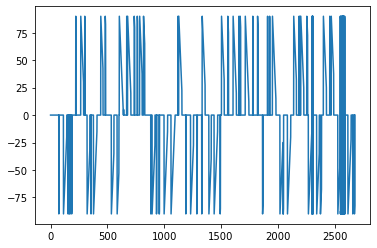

In [142]:
plt.plot(navigator.angles)
plt.show()

In [143]:
from fastai.vision.all import *
from fastai import *
import datetime;
from fastai.vision.widgets import *
import torch 
from math import pi

In [144]:
path = Path('/raid/Images/proxy_reg')

num_img = !ls -l '/raid/Images/proxy_reg' | wc -l

int(num_img[0])

11996

In [145]:
get_image_files(path)

(#11995) [Path('/raid/Images/proxy_reg/03482_-75.0.png'),Path('/raid/Images/proxy_reg/10320_-80.0.png'),Path('/raid/Images/proxy_reg/08476_0.png'),Path('/raid/Images/proxy_reg/00967_0.png'),Path('/raid/Images/proxy_reg/03363_-85.0.png'),Path('/raid/Images/proxy_reg/03039_0.png'),Path('/raid/Images/proxy_reg/11065_0.png'),Path('/raid/Images/proxy_reg/02744_0.png'),Path('/raid/Images/proxy_reg/00858_0.png'),Path('/raid/Images/proxy_reg/05016_-50.0.png')...]

In [51]:
r_path = Path('/raid/Images/test/right')
l_path = Path('/raid/Images/test/left')

In [146]:
torch.cuda.current_device()

1

In [147]:
torch.cuda.set_device(1)

In [148]:
torch.cuda.current_device()

1

In [25]:
sample_lab = "/raid/Images/test/left/00627_-12.4564.png"
deg = float(sample_lab.split('_')[1][:-4])
round(deg, 4)

-12.4564

In [23]:
img_files = get_image_files(path)

In [24]:
im = PILImage.create(img_files[0])
im.shape

(240, 320)

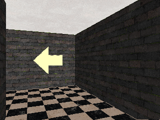

In [25]:
im.to_thumb(160)

In [149]:
def get_deg(f):
    sample_lab = f.name
    deg = float(sample_lab.split('_')[1][:-4])
    return tensor(deg).unsqueeze(0)

In [150]:
db_r = DataBlock(
    blocks=(ImageBlock, RegressionBlock()),
    get_items=get_image_files,
    get_y=get_deg,
    splitter=RandomSplitter(valid_pct=0.2, seed=47),
)

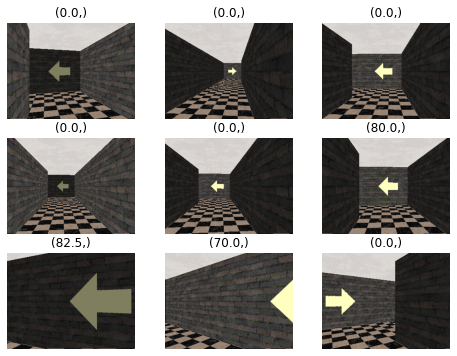

In [151]:
dls_r = db_r.dataloaders(path)
dls_r.show_batch(max_n=9, figsize=(8,6))

In [80]:
xb,yb = dls_r.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1]))

In [60]:
xb[0,0]

TensorImage([[0.8392, 0.8510, 0.8392,  ..., 0.2157, 0.1961, 0.2392],
        [0.8353, 0.8196, 0.8314,  ..., 0.2275, 0.2118, 0.2118],
        [0.8314, 0.8275, 0.8471,  ..., 0.1451, 0.1804, 0.2078],
        ...,
        [0.6078, 0.6078, 0.6196,  ..., 0.3608, 0.2745, 0.2824],
        [0.6078, 0.6078, 0.6078,  ..., 0.2627, 0.3294, 0.3608],
        [0.6078, 0.6196, 0.6275,  ..., 0.0471, 0.1412, 0.0745]],
       device='cuda:1')

In [152]:
learn = cnn_learner(
    dls_r,
    resnet34,
    y_range=(-90, 90),
    metrics=[mse], # , within_45_deg, within_30_deg, within_15_deg
)
learn.fine_tune(
    5,
    cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor="valid_loss", patience=10)],
)

epoch,train_loss,valid_loss,mse,time
0,2950.863525,1771.870117,1771.870117,00:23


Better model found at epoch 0 with valid_loss value: 1771.8701171875.


epoch,train_loss,valid_loss,mse,time
0,1592.938843,969.508118,969.508118,00:30
1,858.095520,575.908875,575.908875,00:30
2,567.355042,535.947205,535.947205,00:30
3,461.675446,489.943573,489.943573,00:30
4,342.954468,486.463928,486.463928,00:30


Better model found at epoch 0 with valid_loss value: 969.5081176757812.
Better model found at epoch 1 with valid_loss value: 575.9088745117188.
Better model found at epoch 2 with valid_loss value: 535.9472045898438.
Better model found at epoch 3 with valid_loss value: 489.9435729980469.
Better model found at epoch 4 with valid_loss value: 486.46392822265625.


In [153]:
learn.export('/home/CAMPUS/eoca2018/raycasting-simulation/Models/regression_model04.pkl')

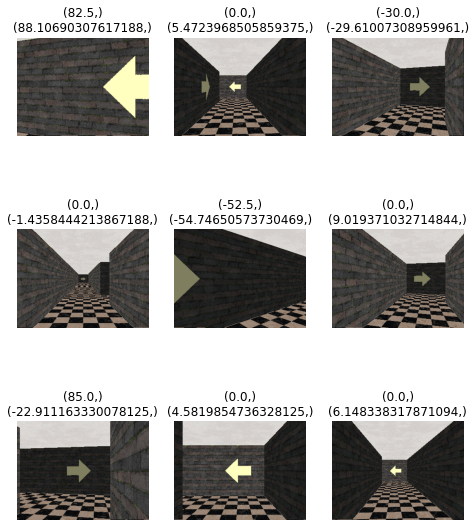

In [154]:
learn.show_results(ds_idx=1, nrows=3, figsize=(8,10))

In [110]:
learn.predict(get_image_files(path)[0])

((17.04332733154297), tensor([17.0433]), tensor([17.0433]))

In [34]:
get_image_files(path)[0]

Path('/raid/Images/test/right/00079_35.0436.png')

# Try Predicting with the Regression Model

In [155]:
import matplotlib.pyplot as plt
import sys
sys.path.append("../PycastWorld")
sys.path.append("../Gym")
from gym_pycastworld.PycastWorldEnv import PycastWorldEnv
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

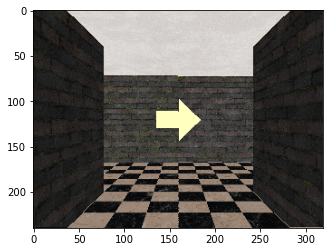

In [156]:
steps_per_episode = 1000

env = PycastWorldEnv("../Mazes/maze01.txt", 320, 240)

path = Path('/home/CAMPUS/eoca2018/raycasting-simulation/Models/regression_model03.pkl')
# Run some number of trials all starting from the
# initial location. We might eventually randomize
# the maze and the starting location.

# Grab the initial observation (not used here)
observation = env.reset()
frames = [observation.copy()]
model_inf = load_learner(path)
prev_pred = 0

plt.imshow(observation)

In [112]:
pred_angle, _, _ =  model_inf.predict(observation)
print(pred_angle)

(-0.6563339233398438,)


(-5.649742126464844,)


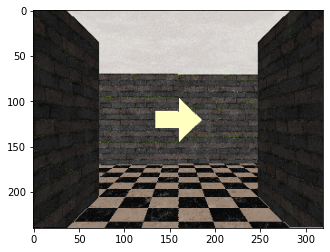

In [114]:
observation, reward, done, info = env.step(1)
plt.imshow(observation)
pred_angle, _, _ =  model_inf.predict(observation)
print(pred_angle)

In [157]:
%%capture
print("Predicting...")
# learn.recorder.silent = True
for t in range(steps_per_episode):    
    pred_angle, _, _ =  model_inf.predict(observation)
    print(pred_angle)
    num_movements = int(pred_angle[0] / 10)
    
    if num_movements < 0:
        num_movements = -1*num_movements
        
    if (prev_pred > 0 and pred_angle[0] < 0) or (prev_pred < 0 and pred_angle[0] > 0):
        print("breaking")
        action_index = 1
        observation, reward, done, info = env.step(action_index)
        frames.append(observation.copy())
        prev_pred = pred_angle[0]
        continue
        
    # check if we have to move opposite
    if abs(prev_pred) > abs(pred_angle[0]):   
        print("opposite angle")
        action_index = 1
        observation, reward, done, info = env.step(action_index)
        frames.append(observation.copy())
    else: 
        action_index = 1
        if pred_angle[0] > 0 and num_movements > 0:
            for i in range(num_movements):
                action_index = 0 # turn left
                observation, reward, done, info = env.step(action_index)
                frames.append(observation.copy())
        elif pred_angle[0] < 0 and num_movements > 0:
            for i in range(num_movements):
                action_index = 2 # turn right
                observation, reward, done, info = env.step(action_index)
                frames.append(observation.copy())
        else:
            action_index = 1
            observation, reward, done, info = env.step(action_index)
            frames.append(observation.copy())
    
    prev_pred = pred_angle[0]
    # Check if we reached the end goal
    if done:
        print(f"  Found goal in {t+1} steps")
        break

print(f"  Ended at position {env.world.x()}, {env.world.y()}")
env.close();

In [ ]:
int(-5.65902709960937/2.5)

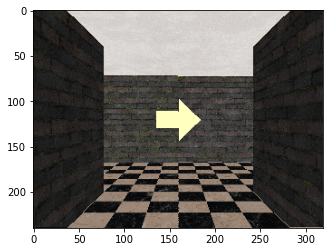

In [158]:
fig, ax = plt.subplots()
ln = plt.imshow(frames[0])
def init():
    ln.set_data(frames[0])
    return [ln]

def update(frame):
#     print(frame)
    ln.set_array(frame)
    return [ln] 

ani = FuncAnimation(fig, update, frames, init_func=init, interval=60)
# plt.show()
# ani.save("prediction_" + str(datetime.datetime.now()) + ".mp4")

In [159]:
smaller_frames = frames[::3] 
ani = FuncAnimation(fig, update, smaller_frames, init_func=init, interval=60)
HTML(ani.to_html5_video())